# Part 1
 Write Python code to read in the 100 aligned sequences, calculate mutual information between all pairs of columns
  and plot these results in the upper 
 triangle of an LxL (72x72) heat map.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [ ]:
# %load_ext watermark
# %watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

In [2]:
def read_msa(msa):
    """ Function which takes in a file consisting of names and sequences on the same line separated by whitespace
    input (string): Name of the file
    output: Two arrays, one containing the names called "names", the other called "sequences" which contains a 72x72 array with all the sequences divided into individual letters as strings
    """
    # Initializes two lists: one called sequence_names for the names and the other called sequences for the sequences
    sequence_names = []
    sequences = []

    with open(msa, "r") as file: # Opens the file with the name as a string
        for line in file: #Iterates over each lines and splits by white space
            #Splits each line by whitespace to separate the sequence name from the actual sequence. Then adds the name to the name list and the sequence to the sequence list
            name, sequence = line.strip().split()
            
            sequence_names.append(name)
            sequences.append(list(sequence))  # Append sequence as a list of strings where each bp is an element in the list
    
    sequences = np.array(sequences)   # Convert sequences to an array

    return sequence_names, sequences
    
names, sequences = read_msa("rna.msa")
# print(sequences)



In [3]:
def make_probmx(sequences):
    """ Function which takes the array of sequences and calculates the probability matrix
    input: Array of sequences
    output: Probability matrix (array) 
    """
    # Defines the length for the empty array and to iterate over
    length = 72
    pmx = np.zeros((length, 4), dtype=float) #creates an empty array called "pmx" that has 72 rows for each 

    nucleotides = {"A": 0, "C": 1, "G": 2, "T": 3} #initializes a dictionary called "nucleotides" with keys that are the nucleotides and values which
                                                ### will correspond to the column index in the pmx matrix 
    
    for i in range(length): # Iterates over all the rows 
        column = sequences[:, i]  #Extracts column of nucleotides at position i out of 72 (each seq is 72 bp long), effectively takes a vertical slice
        for nucleotide in column: #Then for each nucleotide in this column, will tick up the count in the PMX matrix at position i (the position that
                                ### the nucleotide is in) and 0-3 based on whether its an A, C, G, or T. 
            pmx[i, nucleotides[nucleotide]] += 1
    pmx = pmx / 100 #Divides everything by 100, which is the length
    return pmx
pmx = make_probmx(sequences)



In [4]:
def pair_probs(sequences):
    """ Function which takes finds the probability terms pij[a][b] from the sequence list
    Input: array of sequences
    Output: array of 4x4 arrays that gives the probability of each pair of sequences
    """
    num_columns = 72 #Just initializes the variables so I can keep track of number of columns 

    nucleotides = {"A": 0, "C": 1, "G": 2, "T": 3} #initializes a dictionary called "nucleotides," same as in previous function
    
    prob_matrices = np.zeros((num_columns, num_columns, 4, 4)) #Initializes an empty 72x72 array where each point is a 4x4 array
                                                                            #to store the probabilities for pairs of columns
    
    # Iterate over all pairs of columns (i, j) where i < j
    for i in range(num_columns):
        for j in range(i + 1, num_columns):
            # Count occurrences of each codon pair (4x4 matrix)
            count_matrix = np.zeros((4, 4)) #Initializes en empty 4x4 matrix where I can easily add the counts
            
            for seq in sequences: #Iterates over the sequence and pulls out the nucleotides at positions i and j
                nucleotide_i = seq[i]
                nucleotide_j = seq[j]
                
                if nucleotide_i in nucleotides and nucleotide_j in nucleotides: #Because the 4x4 matrix corresponds to pairs of nucleotides, something 
                                                                                #(0,0) will correspond to the pair AA. I can use this to find indexes 
                                                                                # for each individual nucleotide and then tick up where on the 4x4 matrix that is for the pair of nucleotides 
                    index_i = nucleotides[nucleotide_i]
                    index_j = nucleotides[nucleotide_j]
                    count_matrix[index_i, index_j] += 1 ## Ticks up the count matrix at the index corresponding to that base pair
            
            count_matrix = count_matrix / 100 #Normalizes the counts
            prob_matrices[i, j] = count_matrix #Replaces the empty 4x4 matrix in the larger 72x72 array with the counts
            
    return prob_matrices

names, sequences = read_msa("rna.msa")
prob_matrices = pair_probs(sequences)
# prob_matrices


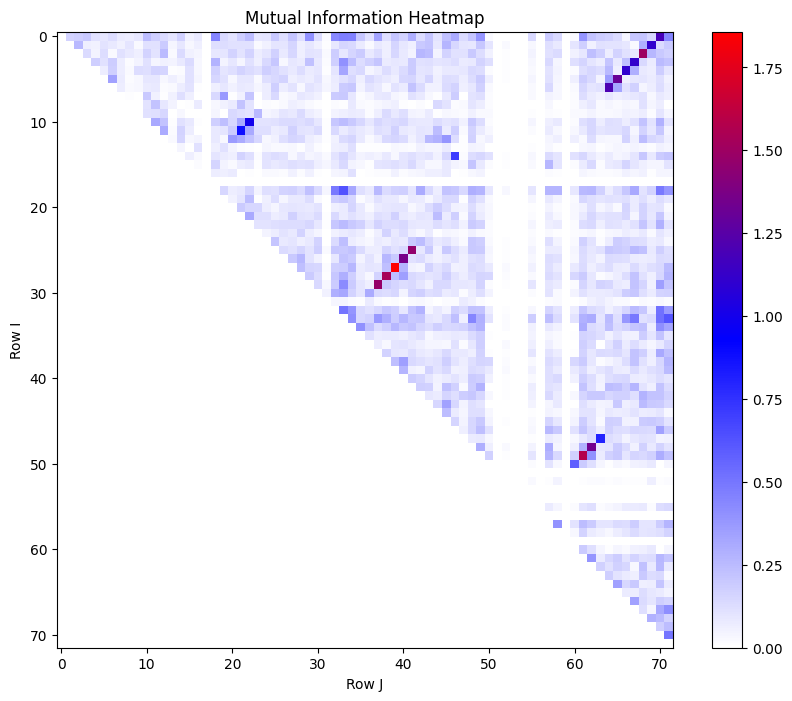

In [5]:
def mutual_information(sequences):
    """ Function which, when given the sequence array, calculates the mutual information as a 72x72 array
    inputs: array of sequences
    outputs: 72x72 array
    """
    num_columns = 72 #Just initializes the variables so I can keep track of number of columns, same as last function

    pmx = make_probmx(sequences) #Calls the make_probmx function and defines it as pmx
    prob_matrices = pair_probs(sequences) #calls the pair_probs function and defines it as prob_matrices
    
    mut_info_matrix = np.zeros((num_columns, num_columns))# Initializes the empty 72x72 array for mutual information between columns
    
    nucleotides = {"A": 0, "C": 1, "G": 2, "T": 3} #initializes a dictionary called "nucleotides," same as in previous function

    # Iterate over all pairs of columns (i, j) where i < j
    for i in range(num_columns):
        for j in range(i + 1, num_columns):
            mut_info = 0 #Sets mutual_info to zero HERE so that it resets to zero after you calculate the mutual information for each pair
            
            for key1, a in nucleotides.items(): #Iterates over the nucleotides dictionary so tha you get every combination of the indexes (0-3), which I
                                                #can use to index into pmx and prob_matrices to calculate the mutual information
                for key2, b in nucleotides.items(): 
                    if pmx[i][a] * pmx[j][b] != 0 and prob_matrices[i][j][a][b] != 0: #Checks to make sure that we don't get zero or infinity in the log. 
                        mut_info += prob_matrices[i][j][a][b] * np.log2(prob_matrices[i][j][a][b] / (pmx[i][a] * pmx[j][b])) #Calculates mutual information for each pair of nucleotides and adds it up for the total                       
            mut_info_matrix[i, j] = mut_info # Adds the total mut_info for two columns to the overall matrix
    return mut_info_matrix
mut_info_matrix = mutual_information(sequences)
# print(mut_info_matrix)

def plot_heatmap(matrix):
    """ Based on the mut_info_matrix, will return a heatmap based on how high the value at each point is
    input: array containing mutual information
    output: heatmap
    """
    
    fig, ax = plt.subplots(figsize=(10, 8)) #Initializes the subplot as shown in class, figsize just makes the figure bigger

    cmap = LinearSegmentedColormap.from_list("custom_cmap", ["white", "blue", "red"]) #Creates a custom color map based off the three colors I provided. I just think it looks a bit clearer this way
    # Define normalization range (0 to max of matrix)
    
    norm = plt.Normalize(vmin=0, vmax=np.max(mut_info_matrix))#I did this so that if I create a heatmap of randomized data, it is normalized to the unshuffled/"original"
                                                             ##dataset. This just sets the baseline to zero and the max to the max of the unshuffled data
    
    cax = ax.imshow(matrix, cmap=cmap, norm = norm) #Plots the heatmap using the input, the color map I provided, and setting the scale to the "norm" 
    
    fig.colorbar(cax) #Makes a colorbar based off of the figure
    
    #Just creates the title/axes labels
    ax.set_title("Mutual Information Heatmap")
    ax.set_xlabel("Row J")
    ax.set_ylabel("Row I")
    
plot_heatmap(mut_info_matrix)


# Part 2
Explain the main features you see in this plot. Do you see evidence for the tRNA cloverleaf? What are some other things or patterns you see?

In this graph, it appears that there are four regions with a notably high MI (by eyeballing it). These are the four diagonals show that there is likely base pairing between (all estimated) 10/11 and 22/23, 1-8 and 63-70, 25-29 and 37-41, and 46-50 and 58-62. The base pairing between 1-8 and 63-70 appears to be the "stem" part of the clover, where the beginning and ends base pair. The base pairing between 10/11 and 22/23 seem to correspond to the first "leaf" of the clover (to the left), the base pairing between 25-29 and 37-41 seems to correspond to the second "leaf" of the clover (pointed down), and the base pairing between 46-49 and 58-61 seems to correspond to the last leaf (to the right). There also seems to be a very large area with no correlation at all to any other nucleotide at around 50-55 which likely corresponds to the end of the leaf (the right one) where there is no base pairing present. These spots of no correlation also appear around base 18, 32, and 58.


# Part 3
Devise a "null hypothesis" and write code to produce an alignment with the same primary sequence conservation statistics as the original MSA, but where pairwise correlations have been randomized.

In [6]:
def shuffle_msa(sequences):
    """ Function which takes the array of sequences and shuffles each column
    input: array of sequences
    output: shuffled array of sequences
    """
    num_col= 72 #Just defines the number of columns for me to iterate over
    
    shuffled_seq = np.copy(sequences) #Creates a copy of the sequence array that I can shuffle
    
    for i in range(num_col): #Iterates over each column and shuffles it
        np.random.shuffle(shuffled_seq[:, i]) 
    
    return shuffled_seq
    
shuffled = shuffle_msa(sequences)
# print(shuffled)


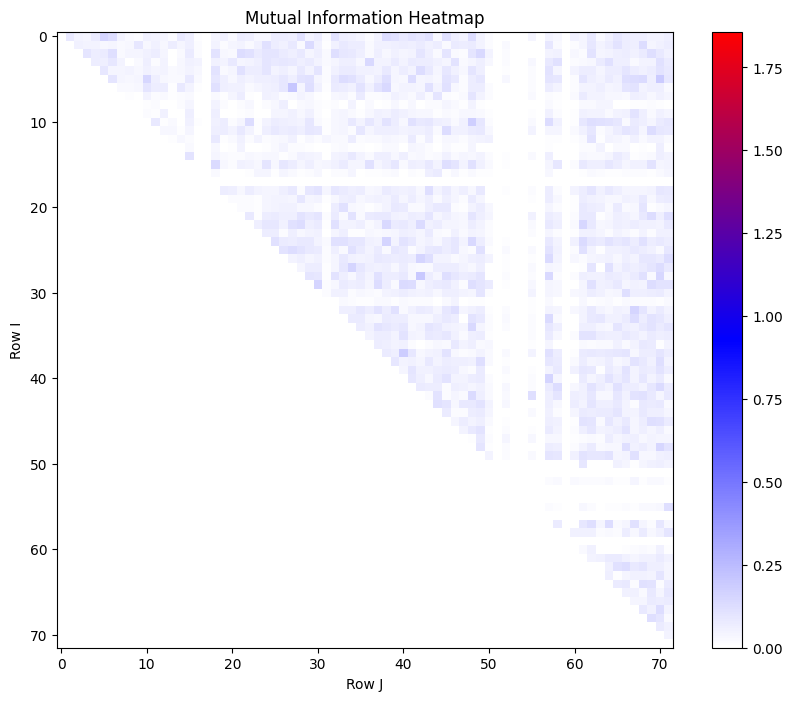

In [8]:
### Example heatmap for one randomized negative control, question only asks for 1 ###
prob_mat_2 = pair_probs(shuffled)
mat_2 = mutual_information(shuffled)
plot_heatmap(mat_2)

# Part 4
Produce a set of many randomized MSAs and calculate mutual information values from them. Plot the distribution P(Mij > t)
 versus varying threshols t 
 for these negative control data -- a so-called complementary cumulative distribution function, also known as a survival function. Also plot the distribution of thMij 
 values from the actual rna.msa alignment. (There are 2556 of them: (L(L-1)/2).) Justify a choice of threshotd 
 for callin Mij n 
 mutual information "significant".

In [9]:
def generate_mi_matrices(sequences, num_shuffles = 10):
    """ Generates many mutual information mutual information matrices 
    inputs: array of sequences (array) and num_shuffles (integer) which is set to 10
    output: array of length num_shuffles where each values is a 72x72 mutual information matrix
    """
    mi_matrices = [] #Initializes an empty list to store my arrays
    for i in range(num_shuffles): #Iterates num_shuffles number of times, randomly shuffles the sequences that many times, and calculates the MI matrix
        shuffled_msa = shuffle_msa(sequences)  # Shuffle the MSA using your shuffle_msa function
        mi_matrix = mutual_information(shuffled_msa)  # Calculate MI matrix for the shuffled MSA
        mi_matrices.append(np.array(mi_matrix))  # Store the MI matrix
    
    return np.array(mi_matrices)
rand_mi = generate_mi_matrices(sequences, 10)
# print(rand_mi)


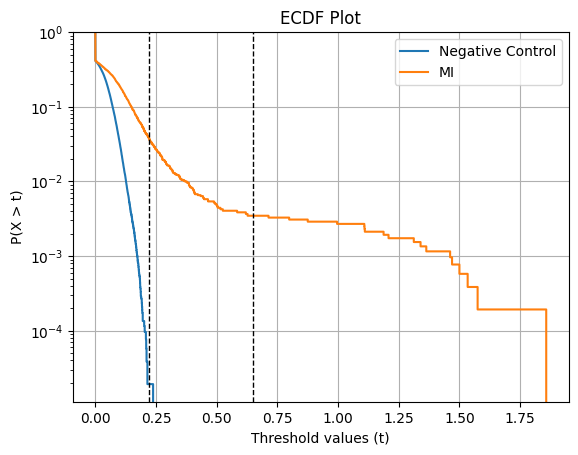

In [10]:
### Create the ECDF plot
fig, ax = plt.subplots() #Initializes the subplot as shown in class

ax.ecdf(rand_mi.flatten(), label = "Negative Control", complementary = True) #Runs the ECDF function with the flattened array so that it is a 1D array
                                                                            ##This also aggregates all the randomized matrices
ax.ecdf(mut_info_matrix.flatten(), label = "MI", complementary = True) #Same as above 

### Sets title and  labels 
ax.set_xlabel("Threshold values (t)")
ax.set_ylabel("P(X > t)")  #Percentage of values greater than t
ax.set_yscale("log") #Make the Y-axis log scale for easier visualization
ax.set_title("ECDF Plot")
ax.legend()
plt.grid(True)
ax.axvline(x = .22, linewidth=1, linestyle="--", color = "black") ### Adds two vertical lines which represent possible thresholds 
ax.axvline(x = .65, linewidth=1, linestyle="--", color = "black")
plt.show()


Justify a choice of threshold t for calling an Mij mutual information "significant". 
One possible threshold to think of is t = .25, which is about the point where we exclude all of the negative control. However, because this is an rna sequence and base pairs are not independent events, this is likely not sufficient. From the graph, it is clear that the slope of the MI line is still quite steep, meaning that there are likely many false positives.
Therefore, I chose t = .65 because this is the point where the MI values of the actual sequence are beginning to plateau. This means that at around this point, false positives are being excluded at a very slow rate, and the mutual information is likely significant. 

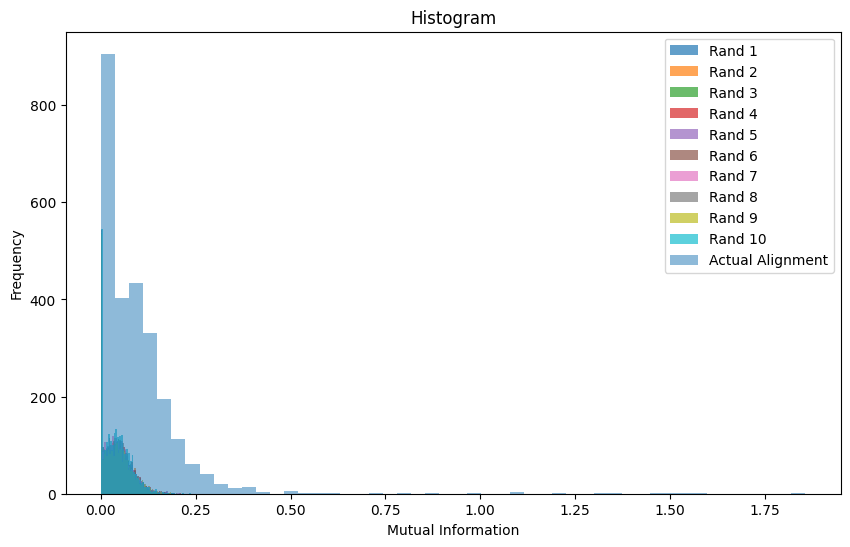

In [11]:
flat = [] #Because I am only looking for how many values in each matrix is greater than the threshold, initializes a list that will only grab the top right of my MI matrix
for i in range(1, 72): #Iterates over each value i<j and adds it to this flattened list
    for j in range(i, 72):
        flat.append(mut_info_matrix[i][j])
        
fig, ax = plt.subplots(figsize = (10,6)) #Initializes the subplot as shown in class, figsize just makes the figure bigger

### Finds/graphs the data for the random alignments
for n in range(10): #Because we are using 10 random sequences, iterates through them
    rand_flat = [] #Initializes an empty list here because I want the a list for each random alignment NOT aggregated 
    for i in range(1, 72): ##Iterates through each index i < j like before and adds it to the flattened list 
        for j in range(i, 72):
            rand_flat.append(rand_mi[n][i][j])
    ax.hist(rand_flat, bins=50, label = f"Rand {n + 1}", alpha=0.7) # Plots this set of data for each ranodmized alignment in the matrix, alpha just affects opacity

ax.hist(flat, bins=50, label = "Actual Alignment", alpha=0.5)  # Plots the histogram for the actual alignment MI data

### Sets graph title/labels
ax.set_title("Histogram")  
ax.set_xlabel("Mutual Information")
ax.set_ylabel("Frequency")
ax.legend()

plt.show()

# Part 5
Extract a list of all the putative consensus base pairs that satisfy your threshold. Compare your list to the list of consensus base pairs expected for tRNA. How many of the expected base pairs are supported by your mutual information analysis? If you see support for other pairs, give a possible explanation for them.

In [12]:
def compare_matrices(threshold):
    """ Function which compares matrices and prints the differences between the consensus base pairs and the putative base pairs
    input: threshold (float)
    output: prints differences
    """
    impor = []
    for i in range(72):
        for j in range (72):
            if mut_info_matrix[i][j] > threshold:
                impor.append((i,j))
    
    consensus = [(0, 70),  (1, 69),  (2, 68),  (3, 67),  (4, 66), (5, 65), (6, 64),   # 7bp acceptor stem
                (9, 23), (10, 22), (11, 21), (12, 20),                               # 4bp D stem
                (25, 41), (26, 40), (27, 39), (28, 38), (29, 37),                     # 5bp anticodon stem
                (47, 63), (48, 62), (49, 61), (50, 60), (51, 59)]  
    con_not_in_impor = []
    for i in consensus:
        if i not in impor:
            con_not_in_impor.append(i)
    print(f"consensus pairs not in putative consensus pairs: {con_not_in_impor}")
    # print(len(con_not_in_impor))
    
    impor_not_in_cons = []
    for i in impor:
        if i not in consensus:
            impor_not_in_cons.append(i)
    print(f"putative pairs not in consensus pairs: {impor_not_in_cons}")
    # print(len(impor_not_in_cons))


In [13]:
print(f"Threshold = .65")
compare_matrices(.65)
print()
print(f"Threshold = .25")
compare_matrices(.25)

Threshold = .65
consensus pairs not in putative consensus pairs: [(9, 23), (12, 20), (50, 60), (51, 59)]
putative pairs not in consensus pairs: [(14, 46)]

Threshold = .25
consensus pairs not in putative consensus pairs: [(51, 59)]
putative pairs not in consensus pairs: [(0, 18), (0, 29), (0, 32), (0, 33), (0, 34), (0, 37), (0, 41), (0, 46), (0, 49), (0, 61), (0, 71), (1, 2), (1, 45), (1, 68), (2, 12), (2, 42), (2, 69), (3, 18), (3, 33), (3, 70), (4, 33), (4, 64), (4, 67), (5, 6), (5, 64), (6, 65), (7, 19), (10, 11), (10, 21), (10, 70), (11, 12), (11, 22), (12, 21), (12, 43), (12, 44), (12, 45), (14, 46), (15, 57), (18, 32), (18, 33), (18, 34), (18, 37), (18, 42), (18, 48), (18, 49), (18, 57), (18, 58), (18, 61), (18, 62), (18, 67), (18, 70), (18, 71), (21, 22), (22, 33), (22, 70), (25, 67), (26, 28), (26, 38), (27, 34), (27, 40), (28, 33), (28, 40), (28, 71), (29, 33), (29, 70), (30, 32), (30, 33), (30, 36), (32, 33), (32, 34), (32, 42), (32, 67), (32, 70), (32, 71), (33, 34), (33, 37

Overall, there are 17 consensus base pairs which are picked up by our threshold t = .65 (only 4 are not picked up). There is only a single putative pair which is picked up that is not in the consensus base pairs. This may be due to noise or random chance, as only a single non-consensus base pair is found. 
When comparing to a much lower threshold t = .25, only one consensus base pair is not picked up (20 consensus base pairs are found). However, there are many putative base pairs that are not in the consensus base pairs, which further demonstrates that this threshold is likely far too low.

# Part 6
Does the mutual information analysis support Wiggins' hypothesis that this conserved region encodes a tRNA?

Yes, this is likely a conserved region encoding a tRNA because the base pairs with mutual information that is significant are extremely similar to the consensus base pairs for tRNA. Furthermore, there are extremely few putative base pairs that are not in the consensus. This supports the distinctive secondary structure of tRNA which resembles a cloverleaf.